In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.use_deterministic_algorithms(True)

In [2]:
# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print ('Number of reviews :', len(review_list))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 76562.09it/s]

Number of reviews : 25000


In [3]:
# pre-processing review text
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

# accumulate all review texts together
reviews_blob = ' '.join(review_list)

# generate list of all words of all reviews
review_words = reviews_blob.split()

# get the word counts
count_words = Counter(review_words)

# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:01<00:00, 20049.20it/s]


[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


In [4]:
# create word to integer (token) dictionary in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [5]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print (reviews_tokenized[0])

ok so it may not be the awardwinning movie of the year typefilm apart from the brilliant soundtrack that i think won a few awards but it is a really great film about the kid prince  o take your pick and the happenings around him living in minneapolis playing his music the music is absolutely superb in my opinion you have to own this soundtrack it is truly a classic and sums up the eighties sounds and feel in a wonderful fashion and the movie itself plays out a nice plot its worth seeing over and over again espeically if you like prince  o which i do of course

[596, 37, 8, 193, 21, 27, 1, 13603, 17, 4, 1, 335, 57550, 952, 35, 1, 524, 799, 11, 9, 102, 1148, 3, 162, 2069, 18, 8, 6, 3, 62, 84, 19, 42, 1, 547, 1822, 2960, 188, 122, 1273, 2, 1, 8386, 183, 88, 567, 7, 22572, 379, 24, 222, 1, 222, 6, 411, 893, 7, 55, 656, 22, 25, 5, 199, 10, 799, 8, 6, 352, 3, 349, 2, 5137, 57, 1, 4354, 918, 2, 231, 7, 3, 373, 1619, 2, 1, 17, 409, 284, 45, 3, 316, 113, 29, 276, 307, 125, 2, 125, 172, 57551, 4

In [7]:
# encode sentiments as 0 or 1
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

reviews_len = [len(review) for review in reviews_tokenized]
print(len(reviews_tokenized))
reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]
print(len(reviews_tokenized))

encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32')


25000
25000


In [8]:
encoded_label_list

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

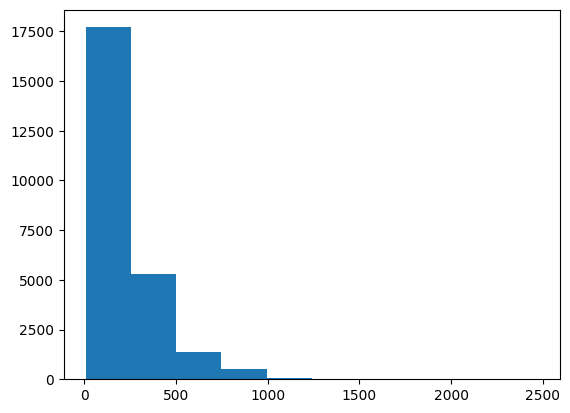

In [9]:
def pad_sequence(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded with 0's or truncated to the sequence_length.
    '''
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

plt.hist(reviews_len);

In [10]:
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

In [11]:
# generate torch datasets
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))


batch_size = 32
# torch dataloaders (shuffle data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [12]:
# get a batch of train data
train_data_iter = iter(train_dataloader)
X_example, y_example = next(train_data_iter)
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[     0,      0,      0,  ...,     30,      3,     17],
        [     0,      0,      0,  ...,     15,   1647,    819],
        [     0,      0,      0,  ...,  10619,     15, 103758],
        ...,
        [     0,      0,      0,  ...,   3481,   1101,   1299],
        [     0,      0,      0,  ...,    311,    160,  22063],
        [  2173,      6,      1,  ...,      9,    242,     13]])

Example Output size:  torch.Size([32])
Example Output:
 tensor([0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.])


In [45]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)  
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        #print("sequence.shape: ", sequence.shape)
        embedding = self.embedding_layer(sequence)
        #print("embeddgin.shape: ", embedding.shape)
        # embedding shape = [sequence_length, batch_size, embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        #print("output.shape: ", output.shape)
        #print("hidden_state.shape: ", hidden_state.shape)
        #print(output[511, 31, :])
        #print(hidden_state[0, 31, :])
        # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size, hidden_dimension]
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))      
        return final_output
    
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 36
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [46]:
print('input: ', X_example.T.shape)
res = rnn_model(X_example.T)
print('output: ', res.shape)

input:  torch.Size([512, 32])
output:  torch.Size([32, 1])


In [47]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float() #convert into float for division 
    accuracy = success.sum() / len(success)
    return accuracy

In [48]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for sequence, sentiment in dataloader:
        optim.zero_grad()     
        preds = model(sequence.T).squeeze()
        
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [49]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            
            preds = model(sequence.T).squeeze()
            
            loss_curr = loss_func(preds, sentiment)   
            accuracy_curr = accuracy_metric(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [50]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start  
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

epoch number: 1 | time elapsed: 75.64763927459717s
training loss: 0.619 | training accuracy: 67.15%
validation loss: 1.075 |  validation accuracy: 24.82%

epoch number: 2 | time elapsed: 79.56514835357666s
training loss: 0.539 | training accuracy: 73.25%
validation loss: 0.898 |  validation accuracy: 48.40%

epoch number: 3 | time elapsed: 79.55825877189636s
training loss: 0.434 | training accuracy: 80.50%
validation loss: 0.942 |  validation accuracy: 53.22%

epoch number: 4 | time elapsed: 77.9752185344696s
training loss: 0.347 | training accuracy: 85.62%
validation loss: 0.982 |  validation accuracy: 55.07%

epoch number: 5 | time elapsed: 83.0432517528534s
training loss: 0.277 | training accuracy: 89.09%
validation loss: 1.010 |  validation accuracy: 53.20%

epoch number: 6 | time elapsed: 77.88593769073486s
training loss: 0.239 | training accuracy: 90.74%
validation loss: 0.871 |  validation accuracy: 66.39%

epoch number: 7 | time elapsed: 78.05372905731201s
training loss: 0.365 

In [51]:
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))
    
    return pred.item()

In [52]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I just really loved the movie"))

0.04785904288291931
0.02483726479113102
0.939608097076416
0.8214504718780518
